Solving mushroom classification problem from https://github.com/pbiecek/InterpretableMachineLearning2020/issues/5

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("dataset_24_mushroom.csv")
#remove aphostrophes from values
for col in data.columns:
    data[col] = data[col].str.replace("'", "")
data.head()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


Target class is in column "class", "p" means poissonous, "e" means eatable. Let's preprocess the data ie. encode classes.

In [3]:
X = data.drop(columns=["class"])
class_enc = preprocessing.LabelEncoder().fit(data["class"])
y = class_enc.transform(data["class"])
encoders = {}
categorical_names = {}
for col in X.columns:
    encoders[col] = preprocessing.LabelEncoder().fit(X[col])
    categorical_names[X.columns.get_loc(col)] = encoders[col].classes_
    X[col] = encoders[col].transform(X[col])

print("Number of samples: %d" % len(y))

Number of samples: 8124


Let's train and evaluate Random Forest model. Using 20% of data as test set.

In [4]:
encoder = preprocessing.OneHotEncoder().fit(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3234)
X_train_enc = encoder.transform(X_train)
classifier = RandomForestClassifier().fit(X_train_enc, y_train)
pred = classifier.predict(encoder.transform(X_test))
acc = np.mean(pred == y_test)
print("Accuracy: %f" % acc)

Accuracy: 1.000000


We have perfect accuracy. Now let's examine feature importances for Random Forest Classifier

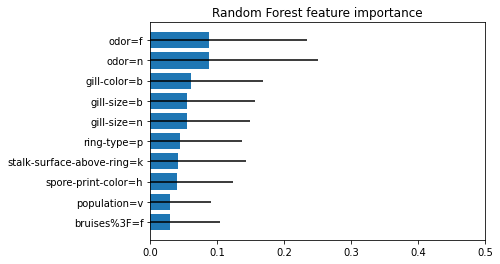

In [5]:
importance_vals = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
indices = np.argsort(importance_vals)#[::-1]

features = []
for i in range(X.shape[1]):
    features = features + [X.columns[i] + '=' + val for val in categorical_names[i]]
features = np.array(features)

# Plot the feature importances of the forest
plt.figure()
plt.title("Random Forest feature importance")
plt.barh(range(10), importance_vals[indices[-10:]],
        xerr=std[indices[-10:]])
plt.yticks(range(10), features[indices[-10:]])
plt.xlim([0, 0.5])
plt.show()

Let's train 3 more models: Logistic Regression, Boosting and Neural Network

In [6]:
logistic_classifier = LogisticRegression().fit(X_train_enc, y_train)
pred = logistic_classifier.predict(encoder.transform(X_test))
acc = np.mean(pred == y_test)
print("Logistic Regression Accuracy: %f" % acc)

boosting_classifier = GradientBoostingClassifier().fit(X_train_enc, y_train)
pred = boosting_classifier.predict(encoder.transform(X_test))
acc = np.mean(pred == y_test)
print("Boosting Accuracy: %f" % acc)

neural_classifier = MLPClassifier().fit(X_train_enc, y_train)
pred = neural_classifier.predict(encoder.transform(X_test))
acc = np.mean(pred == y_test)
print("Neural Network Accuracy: %f" % acc)

Logistic Regression Accuracy: 1.000000
Boosting Accuracy: 1.000000
Neural Network Accuracy: 1.000000


Every model achives perfect accuracy. Let's now examine their feature importances

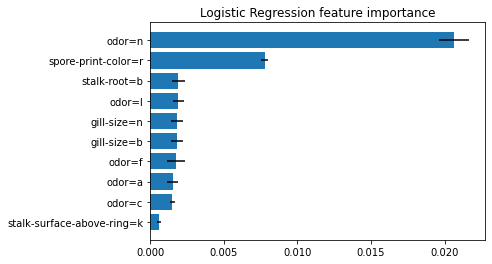

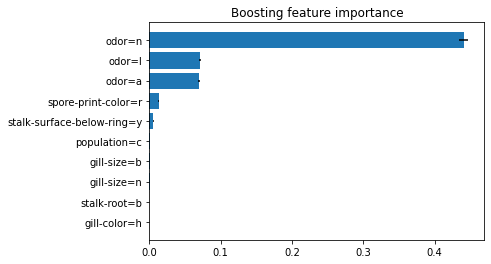

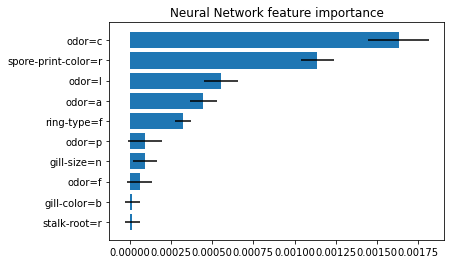

In [7]:
importance = permutation_importance(logistic_classifier, X_train_enc.toarray(), y_train, n_repeats=10)
sorted_idx = importance.importances_mean.argsort()

plt.figure()
plt.title("Logistic Regression feature importance")
plt.barh(range(10), importance.importances_mean[sorted_idx[-10:]],
        xerr=importance.importances_std[sorted_idx[-10:]])
plt.yticks(range(10), features[sorted_idx[-10:]])
#plt.xlim([0, 0.5])
plt.show()

importance = permutation_importance(boosting_classifier, X_train_enc.toarray(), y_train, n_repeats=10)
sorted_idx = importance.importances_mean.argsort()

plt.figure()
plt.title("Boosting feature importance")
plt.barh(range(10), importance.importances_mean[sorted_idx[-10:]],
        xerr=importance.importances_std[sorted_idx[-10:]])
plt.yticks(range(10), features[sorted_idx[-10:]])
#plt.xlim([0, 0.5])
plt.show()

importance = permutation_importance(neural_classifier, X_train_enc.toarray(), y_train, n_repeats=10)
sorted_idx = importance.importances_mean.argsort()

plt.figure()
plt.title("Neural Network feature importance")
plt.barh(range(10), importance.importances_mean[sorted_idx[-10:]],
        xerr=importance.importances_std[sorted_idx[-10:]])
plt.yticks(range(10), features[sorted_idx[-10:]])
#plt.xlim([0, 0.5])
plt.show()

Widzimy, że wszystkie modele są zgodne, że najbardziej istotną cechą jest "odor". Kolejne najważniejsze cechy się już różnią między modelami. Widzimy też różnice między odchyleniami standardowymi: model drzewiasty ma duże odchylenia, pozostałe modele mają znacznie mniejsze, boosting ma najmniejsze (prawie zerowe). Jeszcze jedną różnicą jest skala wyników (proszę spojżeć na osie x).

Wyniki ważności zmiennych zgadzają się z poprzednimi wynikami dla tego problemu. Różnice między modelami mogą być też powodowane faktem, że większość przypadków testowych można poprawnie sklasyfikować z pomocą jednej / 2 cech.

## Appendix: code

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from ceteris_paribus import explainer, profiles
from ceteris_paribus.plots import plots

data = pd.read_csv("dataset_24_mushroom.csv")
#remove aphostrophes from values
for col in data.columns:
    data[col] = data[col].str.replace("'", "")
data.head()

X = data.drop(columns=["class"])
class_enc = preprocessing.LabelEncoder().fit(data["class"])
y = class_enc.transform(data["class"])
encoders = {}
categorical_names = {}
for col in X.columns:
    encoders[col] = preprocessing.LabelEncoder().fit(X[col])
    categorical_names[X.columns.get_loc(col)] = encoders[col].classes_
    X[col] = encoders[col].transform(X[col])

print("Number of samples: %d" % len(y))

encoder = preprocessing.OneHotEncoder().fit(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3234)
X_train_enc = encoder.transform(X_train)
classifier = RandomForestClassifier().fit(X_train_enc, y_train)
pred = classifier.predict(encoder.transform(X_test))
acc = np.mean(pred == y_test)
print("Accuracy: %f" % acc)

importance_vals = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
indices = np.argsort(importance_vals)#[::-1]

features = []
for i in range(X.shape[1]):
    features = features + [X.columns[i] + '=' + val for val in categorical_names[i]]
features = np.array(features)

# Plot the feature importances of the forest
plt.figure()
plt.title("Random Forest feature importance")
plt.barh(range(10), importance_vals[indices[-10:]],
        xerr=std[indices[-10:]])
plt.yticks(range(10), features[indices[-10:]])
plt.xlim([0, 0.5])
plt.show()

logistic_classifier = LogisticRegression().fit(X_train_enc, y_train)
pred = logistic_classifier.predict(encoder.transform(X_test))
acc = np.mean(pred == y_test)
print("Logistic Regression Accuracy: %f" % acc)

boosting_classifier = GradientBoostingClassifier().fit(X_train_enc, y_train)
pred = boosting_classifier.predict(encoder.transform(X_test))
acc = np.mean(pred == y_test)
print("Boosting Accuracy: %f" % acc)

neural_classifier = MLPClassifier().fit(X_train_enc, y_train)
pred = neural_classifier.predict(encoder.transform(X_test))
acc = np.mean(pred == y_test)
print("Neural Network Accuracy: %f" % acc)

importance = permutation_importance(logistic_classifier, X_train_enc.toarray(), y_train, n_repeats=10)
sorted_idx = importance.importances_mean.argsort()

plt.figure()
plt.title("Logistic Regression feature importance")
plt.barh(range(10), importance.importances_mean[sorted_idx[-10:]],
        xerr=importance.importances_std[sorted_idx[-10:]])
plt.yticks(range(10), features[sorted_idx[-10:]])
plt.show()

importance = permutation_importance(boosting_classifier, X_train_enc.toarray(), y_train, n_repeats=10)
sorted_idx = importance.importances_mean.argsort()

plt.figure()
plt.title("Boosting feature importance")
plt.barh(range(10), importance.importances_mean[sorted_idx[-10:]],
        xerr=importance.importances_std[sorted_idx[-10:]])
plt.yticks(range(10), features[sorted_idx[-10:]])
plt.show()

importance = permutation_importance(neural_classifier, X_train_enc.toarray(), y_train, n_repeats=10)
sorted_idx = importance.importances_mean.argsort()

plt.figure()
plt.title("Neural Network feature importance")
plt.barh(range(10), importance.importances_mean[sorted_idx[-10:]],
        xerr=importance.importances_std[sorted_idx[-10:]])
plt.yticks(range(10), features[sorted_idx[-10:]])
plt.show()